In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow

from tensorflow import keras
from uproot_io import Events, View

# Building a CNN for event classification.

We're only using **perfect reconstruction** (cheated files) for this.

1. Need to obtain the truth record for each event, 0 for CC_mu, 1 for CC_e and 2 for NC_x. 


In [3]:
# the data
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")


In [6]:
event_numbers = np.array(list(set(events.event_number)))
event_numbers, len(event_numbers)

(array([   0,    1,    2, ..., 9307, 9308, 9309]), 9310)

# Labelling the events

In [7]:
def labelling():
    label = []
#     bad = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])
                
#         if 13 in mcp and 11 in mcp:
#             bad.append(n)
#             label.append(3)
        
        if 13 in mcp or -13 in mcp:
            label.append(0)

        elif 11 in mcp or -11 in mcp:
            label.append(1)    
            
        else:
            label.append(2)
            
    return np.array(label)

In [8]:
labels = labelling()

In [11]:
np.save('truth_data', labels)

9310


((array([3512.,    0.,    0.,    0.,    0., 3715.,    0.,    0.,    0.,
         2083.]),
  array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
  <BarContainer object of 10 artists>),
 None)

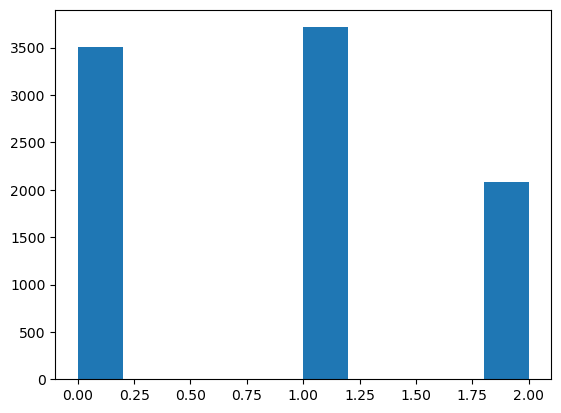

In [9]:
plt.hist(labels), print(len(labels))

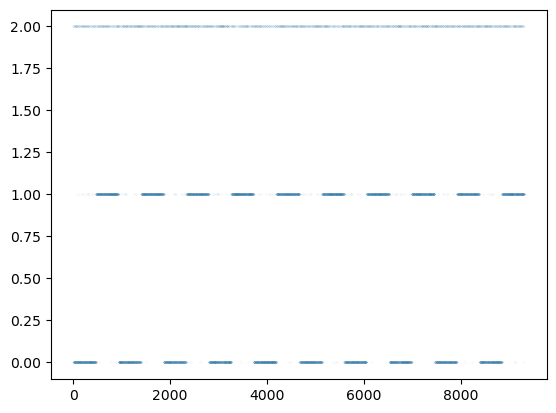

In [10]:
plt.scatter(event_numbers,labels, s=0.001)

In [7]:
def oneHotLabelling():
    label = []
    
    for n in event_numbers:
        mcp = []
        index = np.where(events.event_number == n)[0]

        for i in index:
            parent = events.reco_parent_index[i]
            if parent == 0:
                mcp.append(events.mc_pdg[i])

        if 11 in mcp or -11 in mcp:
            label.append([0,1,0])    
        
        elif 13 in mcp or -13 in mcp:
            label.append([1,0,0])
            
        else:
            label.append([0,0,1])
            
    return np.array(label).astype(float)

In [8]:
one_hot_labels = oneHotLabelling()

# Making the images

In [9]:
view_w = View(events, "w")

In [10]:
def plot_w_event(number):
    x = view_w.x[number]
    z = view_w.z[number]
    adc = view_w.adc[number]
    vx = view_w.true_vtx_x[number]
    vz = view_w.true_vtx_z[number]
    
    plt.scatter(x, z, c=adc, s=0.5)
    plt.scatter(vx, vz, c='red', s=50)
    cbar = plt.colorbar()
    cbar.set_label('ADC')
    plt.xlabel('Time')
    plt.ylabel('W Wire')
    plt.show()

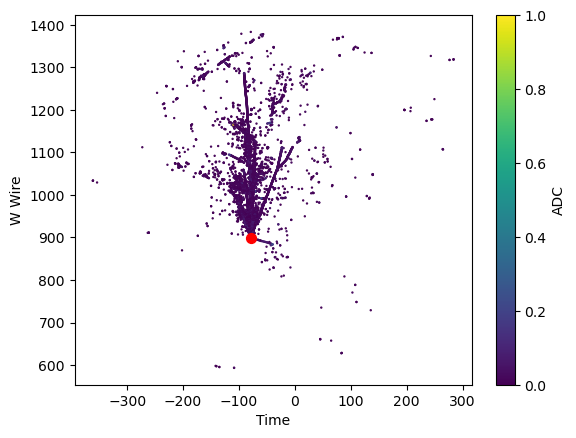

In [11]:
plot_w_event(4223)

In [12]:
def image(n):
    
    images = []
    
#    for n in event_numbers:
    
    x = view_w.x[n]
    z = view_w.z[n]
    adc = view_w.adc[n]

    matrix_size = 128
    matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[min(x), max(x)], [min(z), max(z)]], weights=adc)

    #matrix = np.floor(matrix).astype(np.uint8).reshape(128, 128, 1)
    #images.append(matrix)


    # Display the pixelated image
    plt.imshow(matrix.T, cmap='viridis', origin='lower', extent=[0, 128, 0, 128])
    plt.colorbar()
    #plt.title('Pixelated Image of Energy')
    plt.show()
    
    #return np.stack(images)

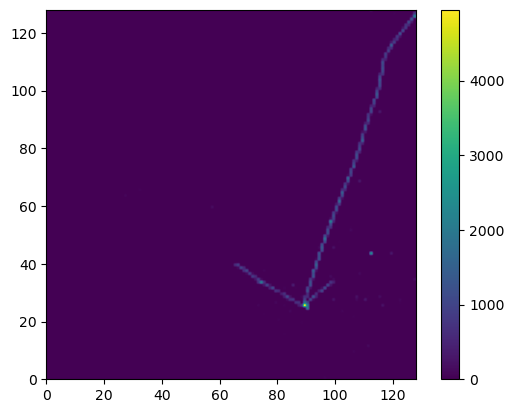

In [13]:
#images = image()
#print(images)
image(333)

In [14]:
def imagenew():
    
    images = []
    
    for n in event_numbers:
    
        x = view_w.x[n]
        z = view_w.z[n]
        adc = view_w.adc[n]
        vx = view_w.true_vtx_x[n]
        vz = view_w.true_vtx_z[n]

        matrix_size = 128
        minusx = np.floor(np.mean(x))-100
        plusx = np.floor(np.mean(x))+100
        minusz = np.floor(np.mean(z))-100
        plusz = np.floor(np.mean(z))+100

        if vx < minusx:
            minusx = np.floor(vx)-20
            plusx = np.floor(vx)+180
        if vx > plusx:
            minusx = np.floor(vx)-180
            plusx = np.floor(vx)+20
        if vz < minusz:
            minusz = np.floor(vz)-20
            plusz = np.floor(vz)+180
        if vz > plusz:
            minusz = np.floor(vz)-180
            plusz = np.floor(vz)+20

        #range=[[np.floor(np.mean(x))-250, np.floor(np.mean(x))+250], [vz-250, vz+250]]

        matrix, xedges, yedges = np.histogram2d(x, z, bins=matrix_size, range=[[minusx, plusx], [minusz, plusz]], weights=adc)
        matrix = (matrix > 0).astype(int)

        matrix = np.floor(matrix).astype(np.uint8).reshape(128, 128, 1)
        images.append(matrix)


    # Display the pixelated image
    #plt.imshow(matrix, cmap='viridis', origin='lower', extent=[0, 256, 0, 256])
    #plt.colorbar()
    #plt.show()
    
    return np.stack(images)

In [15]:
#imagenew(333)

In [16]:
images = imagenew()

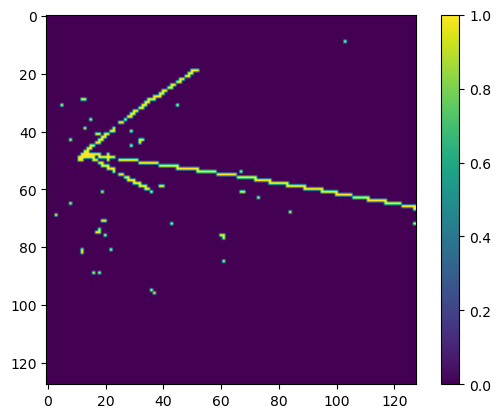

In [17]:
image_to_display = images[333].reshape(128,128)

plt.imshow(image_to_display, cmap='viridis')
plt.colorbar()
plt.show()

In [18]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")
len(testing)
print(training)

[2418 2147 6504 ... 2636 9017  983]


In [19]:
maxi = len(event_numbers)-1
training = [num for num in training if num <= maxi]
testing = [num for num in testing if num <= maxi]

In [20]:
x_train = images[training]
y_train = one_hot_labels[training]

x_test = images[testing]
y_test = one_hot_labels[testing]

In [21]:
print(y_train)

[[0. 1. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 ...
 [0. 1. 0.]
 [0. 1. 0.]
 [0. 1. 0.]]


In [100]:
x_train = np.load('x_train.npy')
y_train = np.load('y_train.npy')
x_val = np.load('x_val.npy')
y_val = np.load('y_val.npy')
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')

In [22]:
num_classes = 3

# The CNN

In [23]:
input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Conv2D(32, (3,3), activation='relu')(input_layer) # Replace None with a 2D convolution with 32 filters of size (3,3) and relu activation
x = keras.layers.MaxPooling2D((2,2))(x) # Replace None with a MaxPooling2D layer to downsample by a factor of 2 in both dimensions
x = keras.layers.Dropout(0.5)(x) # Replace None with a droput layer with a fraction of 0.25
x = keras.layers.Flatten()(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x) # Replace None with a final dense output layer with num_classes neurons and softmax activation
cnn_model = keras.Model(input_layer, x)
cnn_model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 flatten (Flatten)           (None, 127008)            0         
                                                                 
 dense (Dense)               (None, 3)                 381027    
                                                           

In [93]:
input_layer = keras.layers.Input(x_train[0].shape)
x = keras.layers.Rescaling(1./255)
x = keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Dropout(0.25)(x)
x = keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = keras.layers.MaxPooling2D((2, 2))(x)
x = keras.layers.Dropout(0.25)(x)

x = keras.layers.Flatten()(x)
x = keras.layers.Dense(128, activation='relu')(x)
x = keras.layers.Dropout(0.5)(x)
x = keras.layers.Dense(num_classes, activation='softmax')(x)

cnn_model = keras.Model(input_layer, x)
cnn_model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_16 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 dropout_21 (Dropout)        (None, 128, 128, 32)      0         
                                                                 
 conv2d_17 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_17 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                     

In [24]:
# The batch size controls the number of images that are processed simultaneously
batch_size = 128
# The number of epochs that we want to train the network for
epochs = 5
# The learning rate (step size in gradient descent)
learning_rate = 0.001

In [25]:
# Define the loss function - for a multi-class classification task we need to
# use categorical crossentropy loss
loss_function = keras.losses.categorical_crossentropy
# The optimiser performs the gradient descent for us. There are a few different
# algorithms, but Adam is one of the more popular ones
optimiser = keras.optimizers.Adam(learning_rate=learning_rate)
# Now we compile the model with the loss function and optimiser
cnn_model.compile(loss=loss_function, optimizer=optimiser, metrics=['accuracy'])

In [27]:
# Train the model using the training data with the true target outputs.
# Fill in the required arguments using the clues given above
cnn_model.fit(x = x_train, y = y_train, batch_size = batch_size, epochs = epochs,
              validation_data = (x_test, y_test), verbose = 1)

Epoch 1/5


51/51 [==============================] - 23s 422ms/step - loss: 0.8813 - accuracy: 0.5912 - val_loss: 0.7772 - val_accuracy: 0.6563
Epoch 2/5
51/51 [==============================] - 27s 526ms/step - loss: 0.6244 - accuracy: 0.7465 - val_loss: 0.6607 - val_accuracy: 0.7336
Epoch 3/5
51/51 [==============================] - 23s 451ms/step - loss: 0.4697 - accuracy: 0.8327 - val_loss: 0.6177 - val_accuracy: 0.7580
Epoch 4/5
 2/51 [>.............................] - ETA: 18s - loss: 0.3915 - accuracy: 0.8594

KeyboardInterrupt: 

In [44]:
from keras import Model

# Assuming cnn_model is your trained CNN model
layer_name = cnn_model.layers[2].name  # Adjust the index if needed
intermediate_layer_model = Model(inputs=cnn_model.input, outputs=cnn_model.get_layer(layer_name).output)

# Get the output of the first convolutional layer for the first image
index = 668
first_image = x_train[index:index+1]  # Assuming x_train is your dataset
feature_maps = intermediate_layer_model.predict(first_image)

# Get the number of filters
num_filters = feature_maps.shape[3]

# Plot each filter's output
plt.figure(figsize=(15, 200))
#for i in range(num_filters):
    plt.subplot(num_filters, 2, i + 1)
    plt.imshow(feature_maps[0, :, :, i], cmap='viridis', interpolation='nearest')
    plt.title(f'Filter {i + 1}')
    plt.axis('off')

plt.show()

IndentationError: unexpected indent (3098355465.py, line 18)

In [70]:
from tensorflow.keras.models import load_model

cnn_model = load_model('modelv2')
cnn_model.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 256, 256, 1)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 256, 256, 32)      320       
                                                                 
 max_pooling2d_37 (MaxPooli  (None, 128, 128, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_38 (Conv2D)          (None, 128, 128, 64)      18496     
                                                                 
 max_pooling2d_38 (MaxPooli  (None, 64, 64, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_39 (Conv2D)          (None, 64, 64, 128)       738

In [133]:
# Make a list of incorrect classifications
incorrect_indices = []
# Let's look at the whole test dataset, but you can reduce this to 1000 or so
# if you want run more quickly
n_images_to_check = x_test.shape[0]
# Use the CNN to predict the classification of the images. It returns an array
# containing the 10 class scores for each image. It is best to write this code
# using the array notation x[:i] that means use all values of x up until
# the index i, such that if you changed the number of images above then it all
# still works efficiently
raw_predictions = cnn_model.predict(x = x_test[:n_images_to_check], batch_size = batch_size)
for i in range(0,n_images_to_check):
  # Remember the raw output from the CNN gives us an array of scores. We want
  # to select the highest one as our prediction. We need to do the same thing
  # for the truth too since we converted our numbers to a categorical
  # representation earlier. We use the np.argmax() function for this
  prediction = np.argmax(raw_predictions[i])
  truth = np.argmax(y_test[i])
  if prediction != truth:
    incorrect_indices.append([i,prediction,truth])
print('Number of images that were incorrectly classified =',len(incorrect_indices))

22/22 [==============================] - 2s 77ms/step
Number of images that were incorrectly classified = 513


In [46]:
accuracy = (len(testing)-len(incorrect_indices))/len(testing)
print(accuracy)

0.8143216984526809


In [134]:
loss, accuracy = cnn_model.evaluate(x_test, y_test)

88/88 [==============================] - 2s 23ms/step - loss: 0.5595 - accuracy: 0.8163


Incorrect classification for image/event 6 3350 : predicted = 2 with true = 1


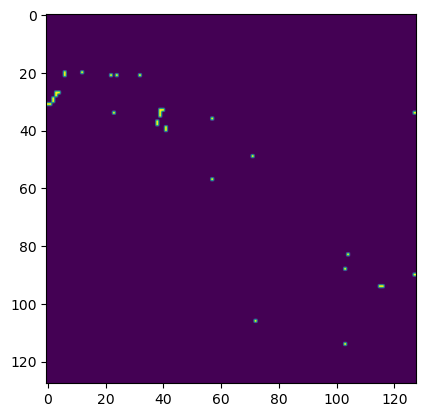

Incorrect classification for image/event 10 8320 : predicted = 1 with true = 2


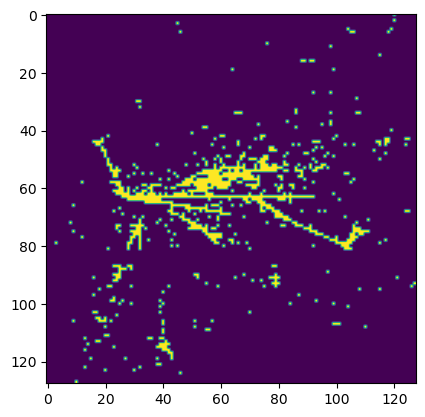

Incorrect classification for image/event 13 374 : predicted = 1 with true = 0


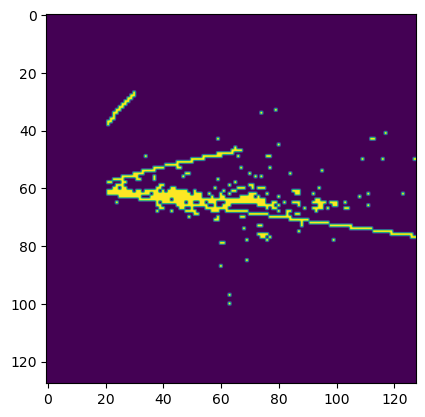

Incorrect classification for image/event 17 5971 : predicted = 0 with true = 2


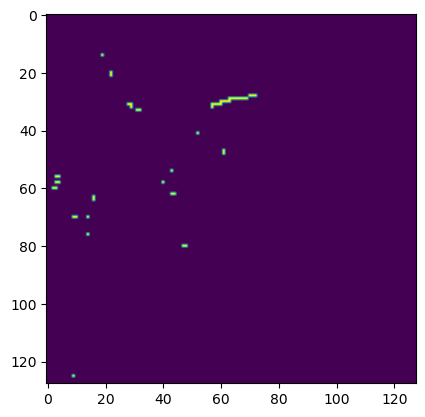

Incorrect classification for image/event 19 4749 : predicted = 2 with true = 1


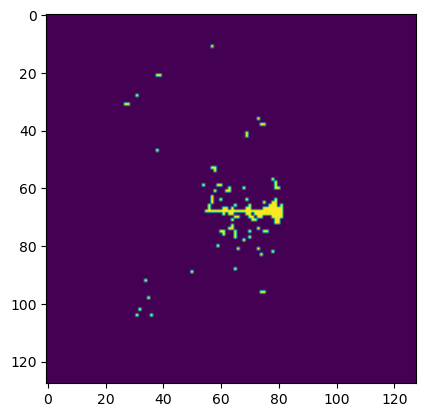

Incorrect classification for image/event 23 7656 : predicted = 0 with true = 2


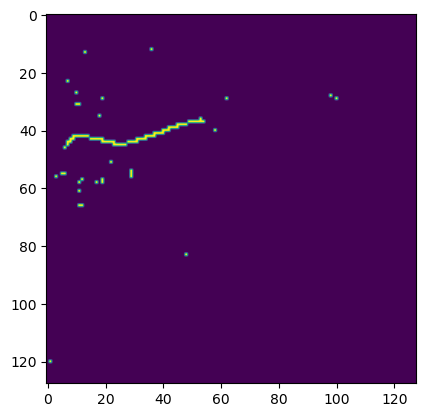

Incorrect classification for image/event 30 379 : predicted = 0 with true = 1


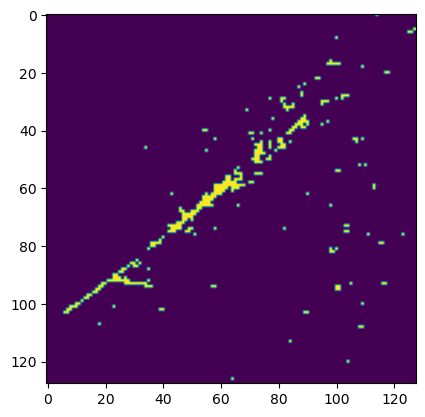

Incorrect classification for image/event 32 4190 : predicted = 1 with true = 0


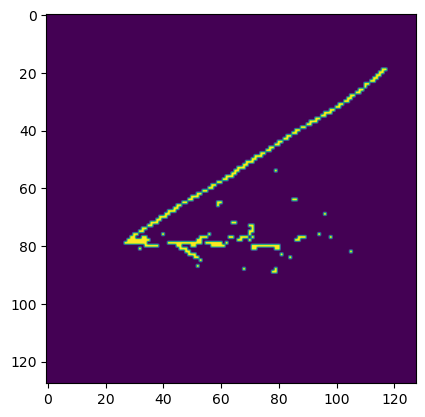

Incorrect classification for image/event 35 2562 : predicted = 1 with true = 2


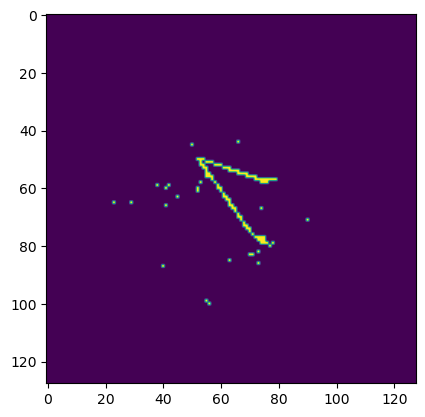

Incorrect classification for image/event 39 6214 : predicted = 2 with true = 1


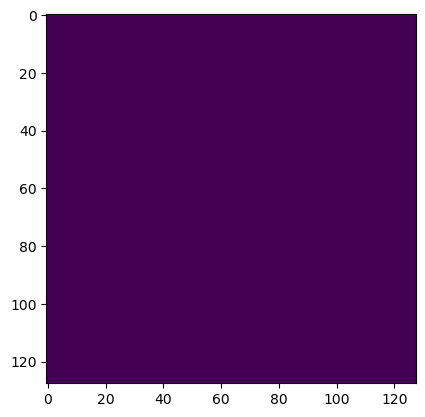

Incorrect classification for image/event 45 7278 : predicted = 0 with true = 1


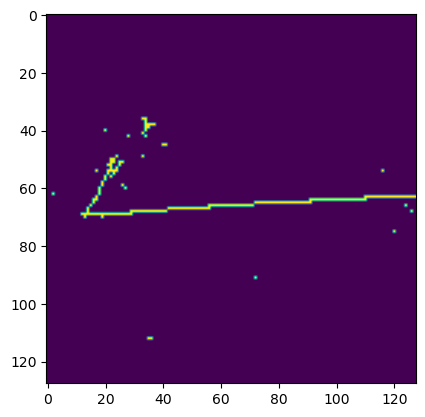

Incorrect classification for image/event 47 8229 : predicted = 0 with true = 1


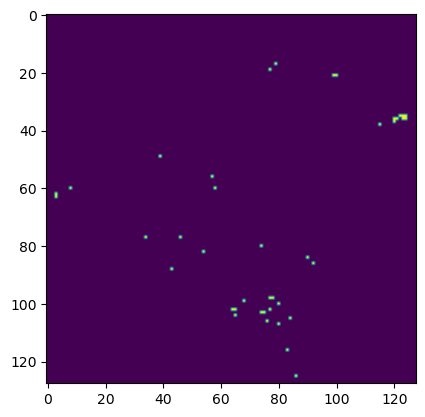

Incorrect classification for image/event 57 9139 : predicted = 0 with true = 1


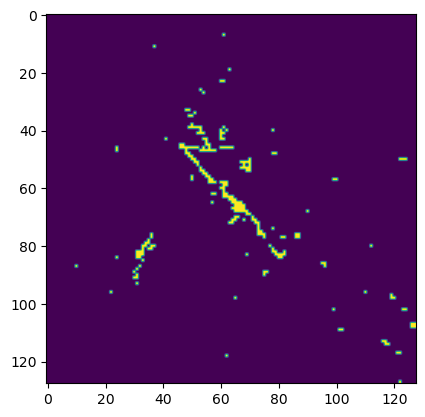

Incorrect classification for image/event 73 6900 : predicted = 2 with true = 0


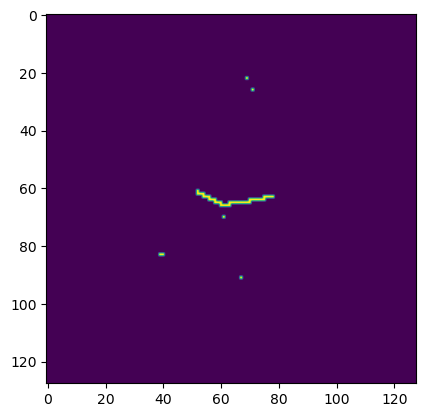

Incorrect classification for image/event 75 8137 : predicted = 0 with true = 1


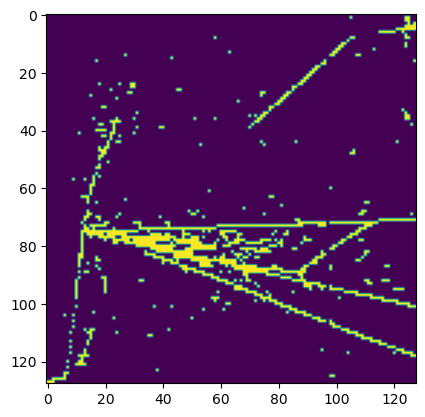

Incorrect classification for image/event 80 8689 : predicted = 1 with true = 2


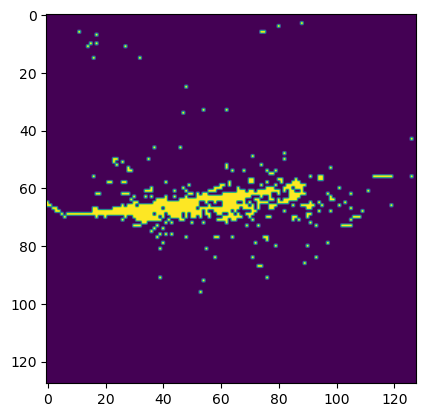

Incorrect classification for image/event 81 4025 : predicted = 0 with true = 2


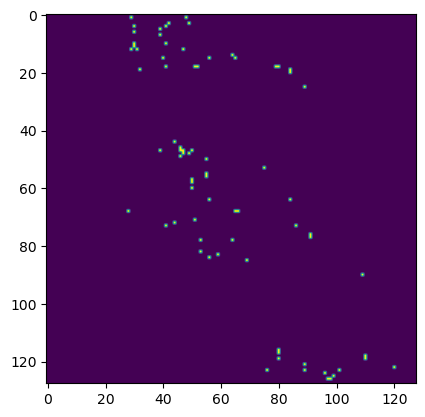

Incorrect classification for image/event 83 3370 : predicted = 0 with true = 2


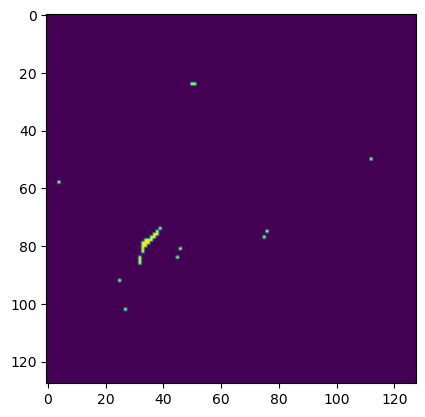

Incorrect classification for image/event 88 2579 : predicted = 2 with true = 0


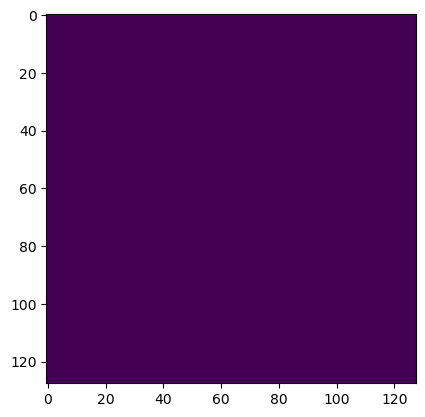

Incorrect classification for image/event 92 9124 : predicted = 0 with true = 2


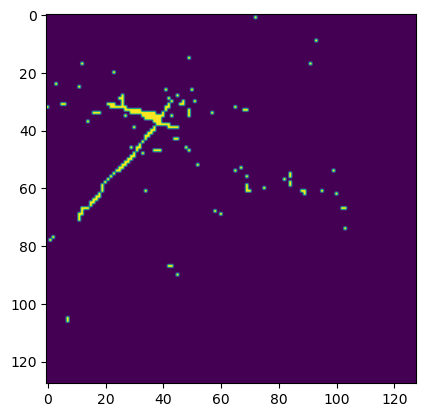

Incorrect classification for image/event 93 9039 : predicted = 2 with true = 0


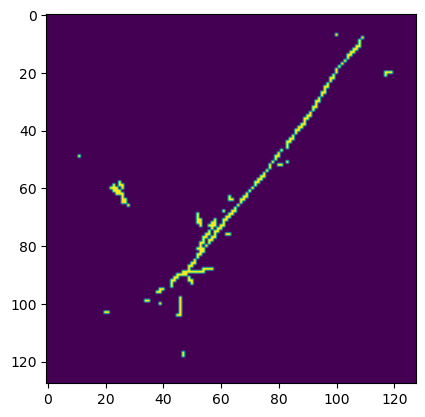

Incorrect classification for image/event 95 2391 : predicted = 0 with true = 1


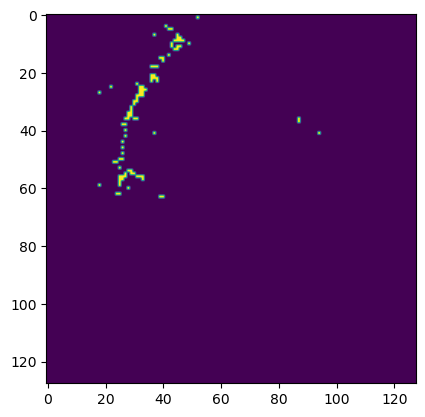

Incorrect classification for image/event 97 4882 : predicted = 2 with true = 0


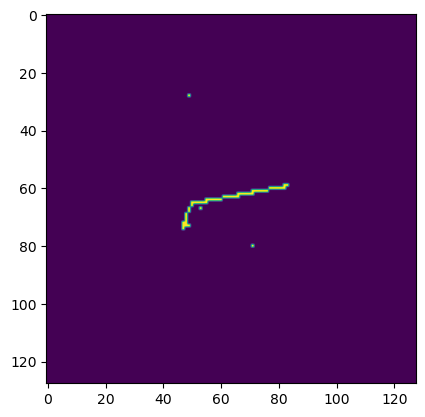

Incorrect classification for image/event 101 787 : predicted = 0 with true = 1


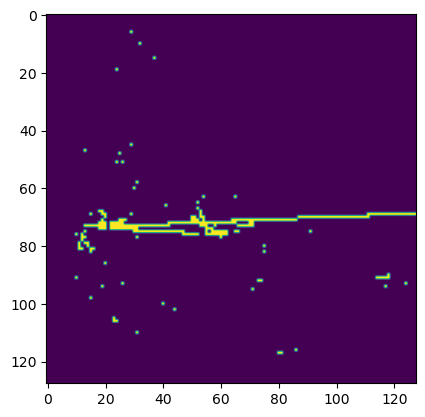

Incorrect classification for image/event 104 503 : predicted = 0 with true = 1


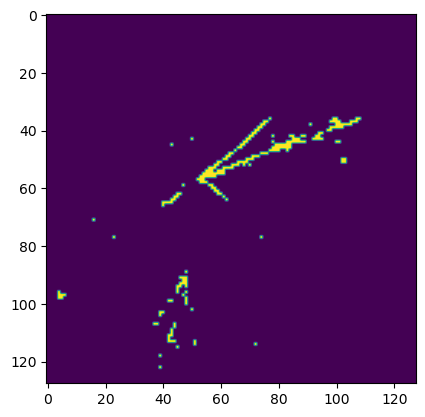

Incorrect classification for image/event 111 9256 : predicted = 1 with true = 2


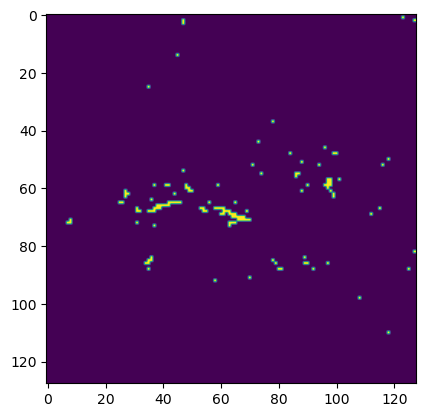

Incorrect classification for image/event 114 5270 : predicted = 1 with true = 2


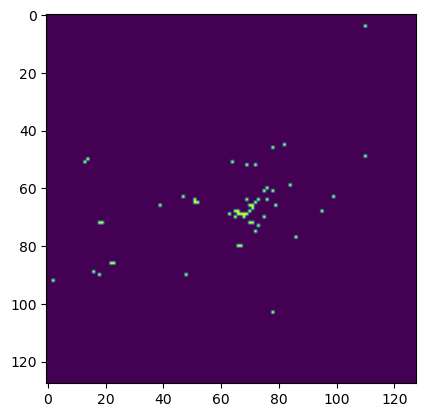

Incorrect classification for image/event 122 8951 : predicted = 2 with true = 0


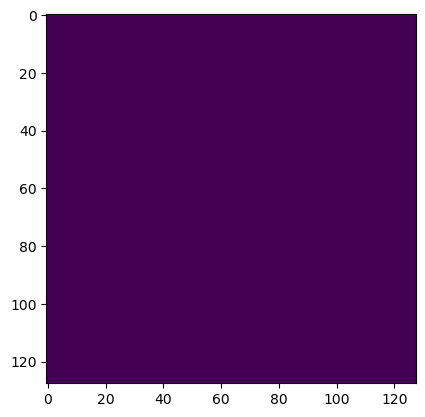

Incorrect classification for image/event 125 2801 : predicted = 2 with true = 0


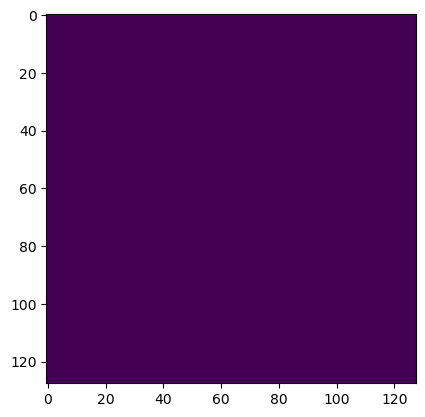

Incorrect classification for image/event 126 8059 : predicted = 2 with true = 1


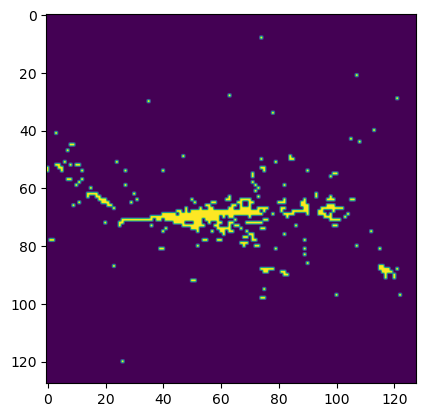

Incorrect classification for image/event 131 3387 : predicted = 2 with true = 0


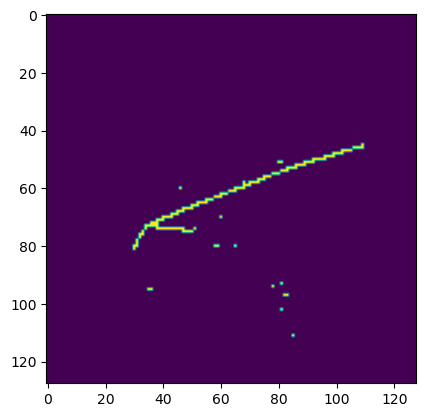

Incorrect classification for image/event 135 349 : predicted = 1 with true = 0


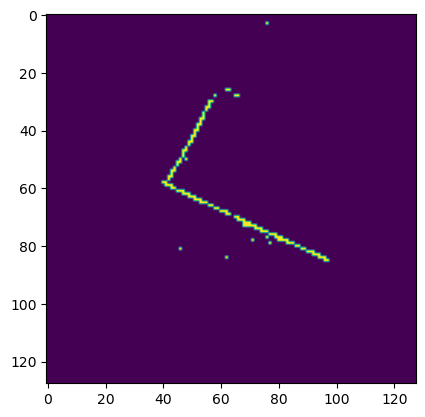

Incorrect classification for image/event 136 8698 : predicted = 2 with true = 1


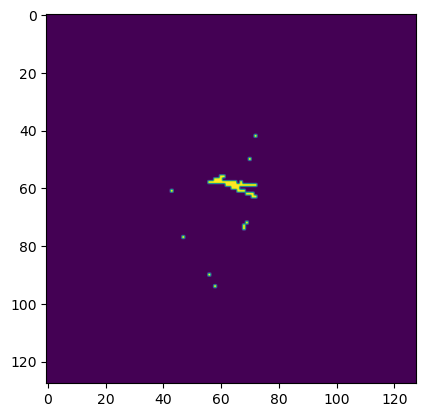

Incorrect classification for image/event 143 81 : predicted = 1 with true = 2


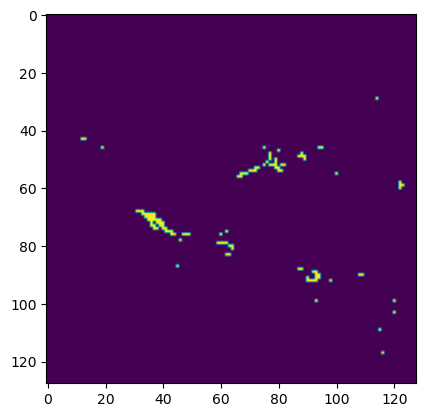

Incorrect classification for image/event 146 6077 : predicted = 0 with true = 1


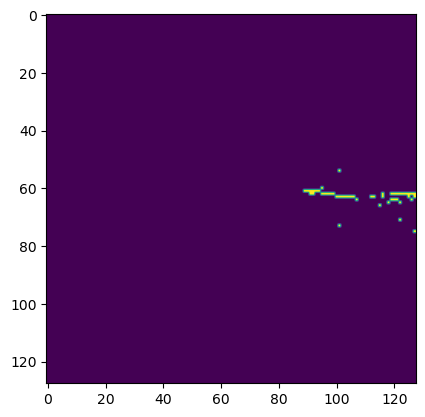

Incorrect classification for image/event 152 2276 : predicted = 1 with true = 2


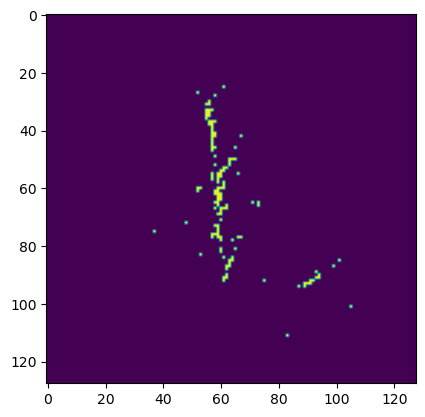

Incorrect classification for image/event 154 2221 : predicted = 2 with true = 1


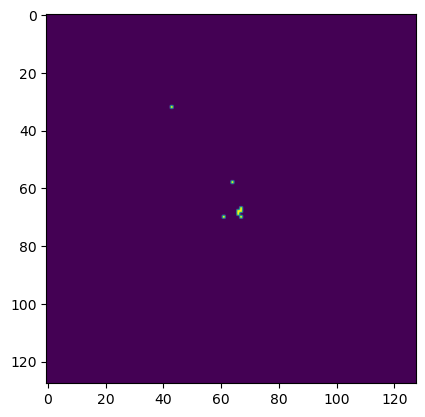

Incorrect classification for image/event 160 1446 : predicted = 0 with true = 2


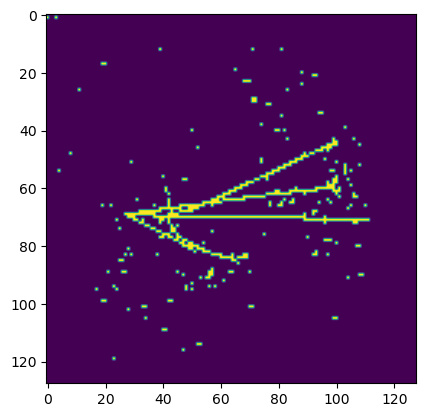

Incorrect classification for image/event 169 5314 : predicted = 1 with true = 2


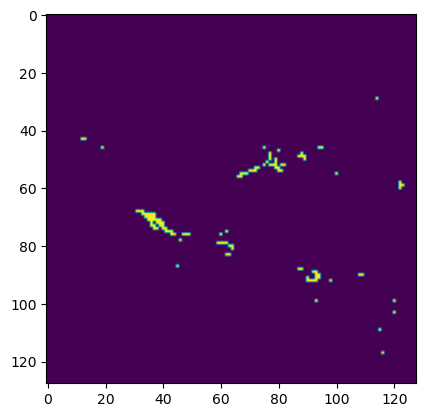

Incorrect classification for image/event 175 8384 : predicted = 0 with true = 2


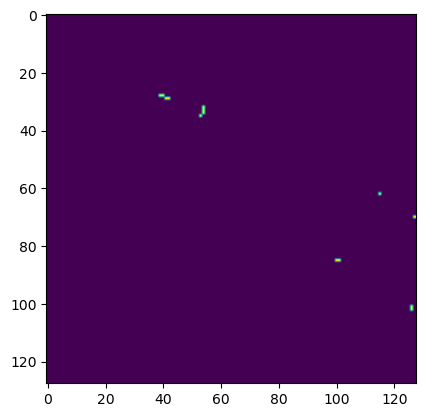

Incorrect classification for image/event 184 7570 : predicted = 0 with true = 1


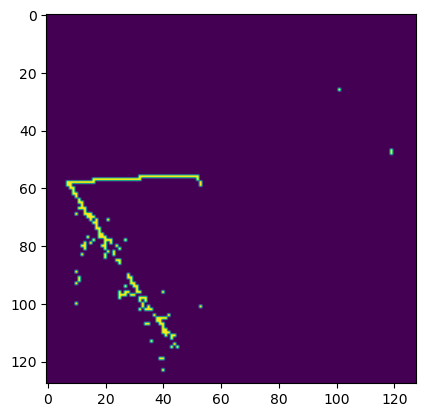

Incorrect classification for image/event 185 694 : predicted = 1 with true = 2


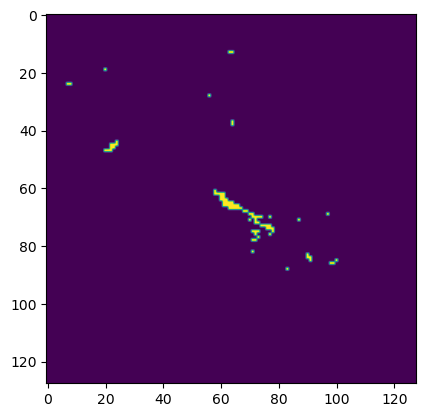

Incorrect classification for image/event 220 6941 : predicted = 0 with true = 1


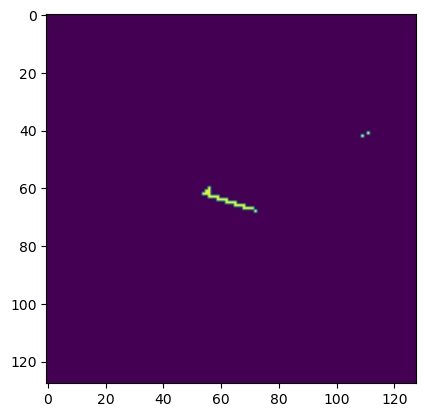

Incorrect classification for image/event 222 6392 : predicted = 2 with true = 1


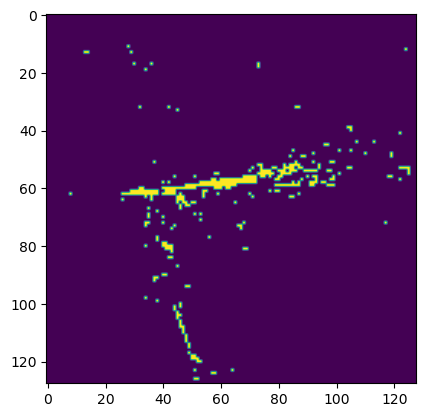

Incorrect classification for image/event 229 8334 : predicted = 1 with true = 0


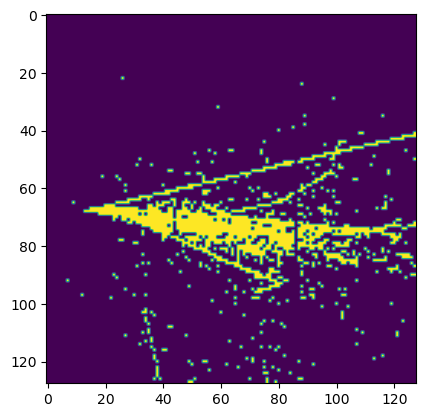

Incorrect classification for image/event 234 5545 : predicted = 1 with true = 2


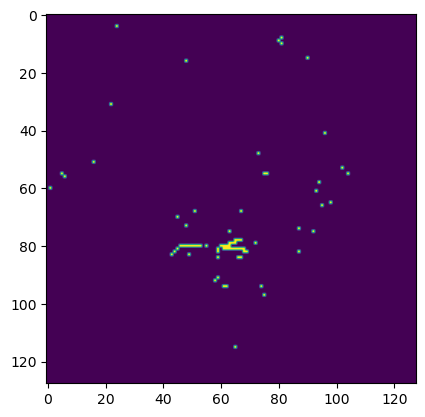

Incorrect classification for image/event 239 5144 : predicted = 1 with true = 0


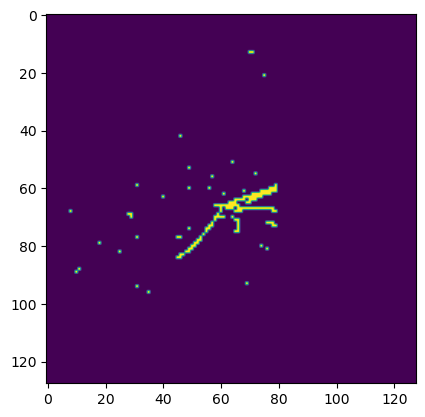

Incorrect classification for image/event 242 3681 : predicted = 2 with true = 0


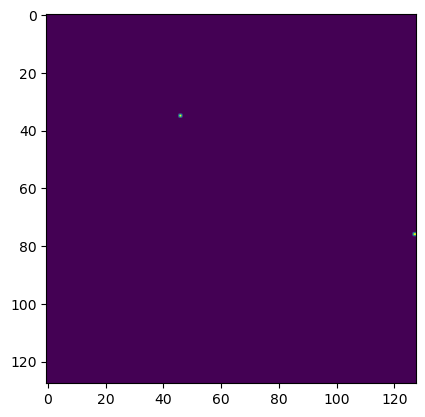

Incorrect classification for image/event 251 5437 : predicted = 0 with true = 2


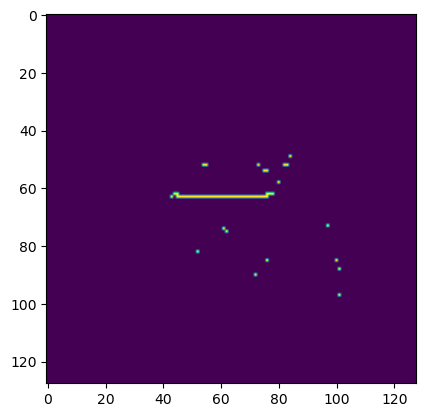

Incorrect classification for image/event 260 1722 : predicted = 2 with true = 1


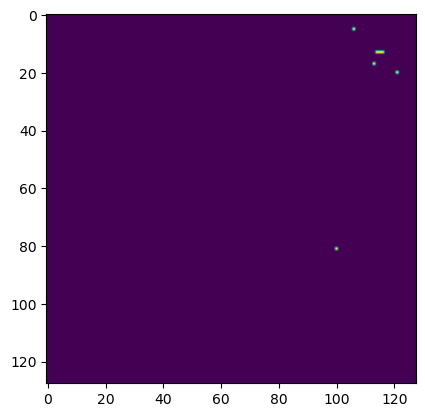

In [135]:
# Now you can modify this part to draw different images from the failures list
# You can change the value of im to look at different failures
im = 9
#image_to_plot = x_test[incorrect_indices[im][0]]
#fig, ax = plt.subplots(1, 1)
#index = incorrect_indices[im][0]
#print('Incorrect classification for image/event',incorrect_indices[im][0], testing[index],
#      ': predicted =',incorrect_indices[im][1],
#      'with true =',incorrect_indices[im][2])
#ax.imshow(image_to_plot)

for i in range(0, 1):
    print('Incorrect classification for image/event',incorrect_indices[i][0], testing[i],
      ': predicted =',incorrect_indices[i][1],
      'with true =',incorrect_indices[i][2])
    image_to_plot = x_test[incorrect_indices[i][0]]
    fig, ax = plt.subplots(1, 1)
    ax.imshow(image_to_plot)
    plt.show()

In [136]:
from sklearn.metrics import confusion_matrix

preds = []
trut = []
for i in range(0,n_images_to_check):
    prediction = np.argmax(raw_predictions[i])
    truth = np.argmax(y_test[i])
    preds.append(prediction)
    trut.append(truth)
    
conf_matrix = confusion_matrix(trut, preds)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]


In [137]:
conf_matrix_decimals

array([[0.83162791, 0.08186047, 0.08651163],
       [0.06126126, 0.86306306, 0.07567568],
       [0.10361842, 0.19243421, 0.70394737]])

Text(50.722222222222214, 0.5, 'True Label')

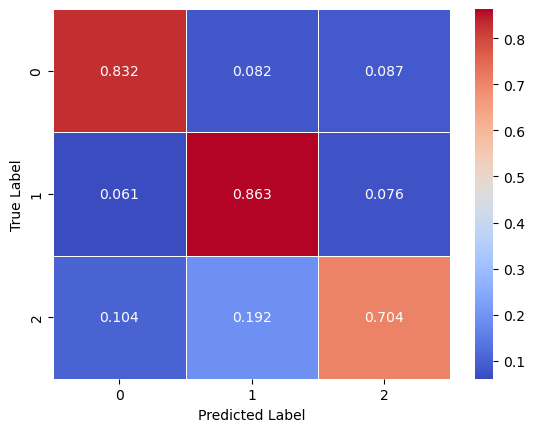

In [138]:
import seaborn as sns
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')